**In this project, we analyze the real world stock market data, and create a investment portfolio of stocks with minimal real-world volatility.**

In [1]:
#Package Import
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
import scipy.stats as stats

from scipy.optimize import minimize

%run Functions.py

In [2]:
ticker = ['BAC','YUM','CSCO','COST','NFLX','BP','TM'] 
stock_index = yf.download(ticker, period = '5y', interval = '1d')

C:\TEMP\ipykernel_3332\2851625031.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_index = yf.download(ticker, period = '5y', interval = '1d')
[*********************100%***********************]  7 of 7 completed


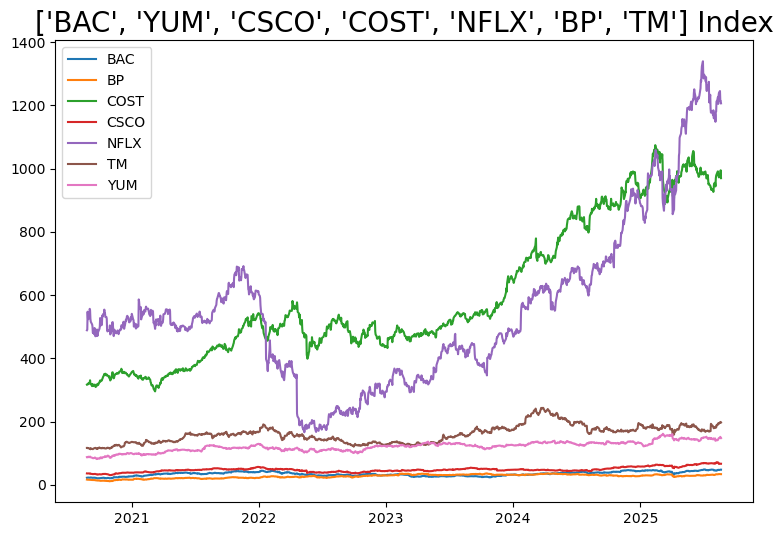

In [3]:
plt.figure(figsize=(9,6))

# Plot each stock/simulation path with a label
for col in stock_index['Close'].columns:
    plt.plot(stock_index['Close'][col], label=col)

plt.title(f'{ticker} Index', size=20, color='black')
plt.legend()  # Show the legend with labels
plt.show()


In the following, we determine the least "oscillatory" portfolio (that is, a linear combination of assets which acquires a minimal realized volatility) under the assumption that the logarithm for stock prices satisfy a Geometric Brownian Motion. This follows the general scheme for modern stock investment strategy proposed by Harry Markowitz.

More precisely, for our chosen $N = ???$ stocks $S_i$'s, we assume that the random variables $\log(S_i)$'s to satisfy Geometric Brownian Motions.
Assuming that we start with $V_0$ amount of capital, and thoughout a time window $[0,T]$, we invest into our chosen $N$ stocks and adjust the share we hold daily. Denoting the $i$-th stock's price on day $d$ to be $S_i(d)$ and our portfolio value as $V(d)$ (thus $V(0) = V_0$), we hold $n_i(d) = \frac{w_i\cdot V(d)}{S_i(d)}$ on $d$-th day during $[0,T]$. Here $w_i$'s are weights to be assigned to different stocks, satisfying $\sum w_i = 1$ and $\min(w_i) \geq 0$.
Then, the portfolio value on day $d$ shall be: 
$$ V(d) = \sum_{i=1}^N n_i(d)S_i(d),$$
while the daily return on day $d \geq 1$ is:
$$ \frac{V(d) - V(d-1)}{V(d-1)} = \sum^{N}_{i=1}w_i\cdot \frac{S_i(d) - S_i(d-1)}{S_i(d-1)},$$
in which $\frac{S_i(d) - S_i(d-1)}{S_i(d-1)} \approx \log(S_i(d))/\log(S_i(d-1))$ as $d - (d-1) = 1$ is a small time shift (recall that $\log(x+1) = x + O(x^2)$).
Denoting the daily log return for $S_i$, given by $\log(S_i(d)/S_i(d-1))$ on day $d$, as $R_i(d)$, then $R_i(d)$ is a random variable as $d$ varies, and the (annualized) volatility for our investment portfolio would (roughly) be:
$$ \text{Annualized Portfolio Volatility} = \sqrt{\vec{w} \cdot \text{Cov}(R_i) \cdot \vec{w}^T},$$
where $\vec{w} = [w_1,..., w_N]$ is the vector formed by the weights while $\text{Cov}(R_i)$ is the covariance matrix of $R_i$'s.

In [4]:
# In the following we realize the above volatility minimization process.

n_days = 60
min_weight = 0.05

stock_history = stock_index['Close'][ticker]
optimized_weight = weight_optimization_1(ticker, stock_history, n_days, min_weight)  # Minimizing the annulaized portfolio volatility.

vol_dict = {}

for t in ticker:
    vol = np.sqrt(252)*(volatility(stock_history[t]))
    print(f'The annualize volatility for the log return of {t} in the past {n_days} days is {vol}')
    vol_dict[t] = vol


portfolio_prices = stock_history.iloc[-n_days:] @ optimized_weight
port_vol = np.sqrt(252) * volatility(portfolio_prices)
print(f'The annualized volatility for the log return of our portfolio in the past {n_days} is {port_vol}')

vol_dict['Portfolio'] = port_vol

The annualize volatility for the log return of BAC in the past 60 days is 4.508466412052422
The annualize volatility for the log return of YUM in the past 60 days is 3.2045996922607123
The annualize volatility for the log return of CSCO in the past 60 days is 3.6163007960572786
The annualize volatility for the log return of COST in the past 60 days is 3.612096687530748
The annualize volatility for the log return of NFLX in the past 60 days is 7.223666261175688
The annualize volatility for the log return of BP in the past 60 days is 4.938666747955703
The annualize volatility for the log return of TM in the past 60 days is 4.116037268799928
The annualized volatility for the log return of our portfolio in the past 60 is 2.2455654518962644


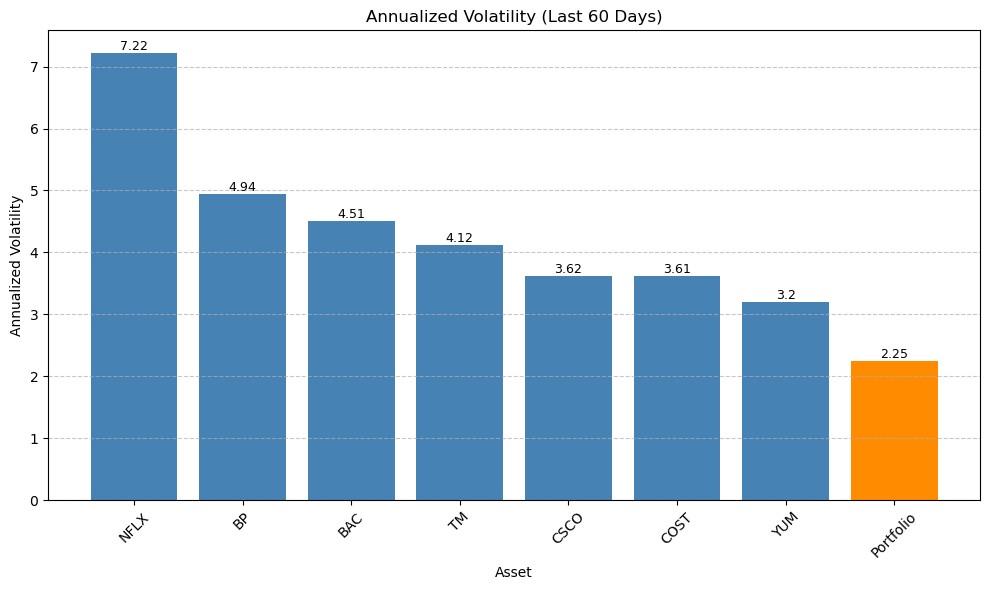

In [5]:
# visualizing the reduction in volatility after optimization.

sorted_vol_dict = dict(sorted(vol_dict.items(), key=lambda x: x[1], reverse=True))

# Extract labels and values
labels = list(sorted_vol_dict.keys())
values = list(sorted_vol_dict.values())

# Assign colors: one color for stocks, one for portfolio
colors = ['steelblue' if label != 'Portfolio' else 'darkorange' for label in labels]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors)

# Annotate bars with exact values
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.3}',
             ha='center', va='bottom', fontsize=9)

plt.xlabel('Asset')
plt.ylabel('Annualized Volatility')
plt.title(f'Annualized Volatility (Last {n_days} Days)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:
stock_history = pd.DataFrame(stock_history)
risk_free_rate = 0
max_weight = 0.25
min_weight = 0.05
min_constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq','fun': lambda weights: max_weight - np.max(weights)},
               {'type': 'ineq','fun': lambda weights: np.min(weights) - min_weight}] 

def target_function(weights):
    return -Ann_Sharpe_Ratio(stock_history, weights, risk_free_rate)

initial_weights = np.array([1/len(ticker)]*len(ticker))
result = minimize(target_function, initial_weights,method='SLSQP', constraints=min_constraints)

weight_mat = pd.DataFrame(index=['Ticker', 'Weight'], columns=range(len(ticker)))

for t in range(len(ticker)):
    weight_mat.at['Ticker', t] = ticker[t]
    weight_mat.at['Weight', t] = result.x[t]

print(f' The Sharpe Ratio of our portfolio with risk free interest {risk_free_rate} is {-result.fun}, with weights:')
print(weight_mat.to_string(index=True, header=False))

 The Sharpe Ratio of our portfolio with risk free interest 0 is 0.9523276865712542, with weights:
Ticker       BAC       YUM      CSCO  COST      NFLX        BP        TM
Weight  0.107763  0.227782  0.150884  0.25  0.063073  0.150395  0.050104
